In [4]:
from QAOA import QAOArunner
from MaxCutProblem import MaxCutProblem
import params
from rustworkx.visualization import mpl_draw as draw_graph
from load_data import load_graph_from_csv

[(0, 3, 0.2860989214262264), (6, 3, 0.3671102795653327), (2, 0, 0.9455705208476514), (3, 5, 0.7652935868437997), (4, 1, 0.04685910927919679), (3, 1, 0.47956402442269863), (4, 2, 0.19724272630551287), (4, 0, 0.07195385951138711), (1, 6, 0.7542356291523078), (4, 3, 0.7975811256880307)]


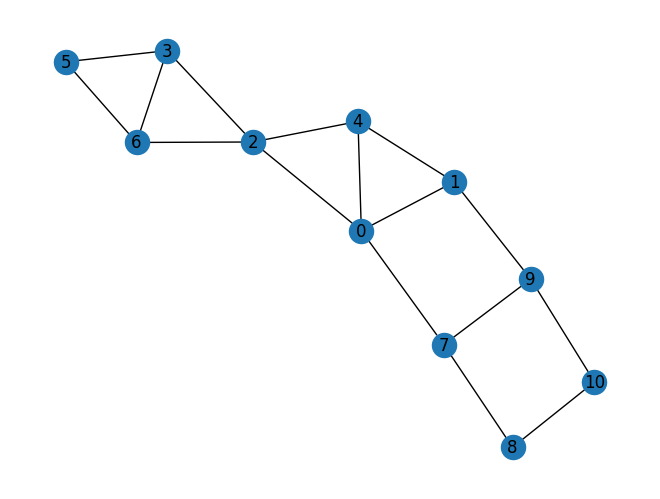

In [5]:
problem = MaxCutProblem()
graph = problem.get_graph(params.graph_size, create_random=True,random_weights=True)
graph = load_graph_from_csv('data/11_nodes_links_scand.csv')
draw_graph(graph, with_labels=True)

In [14]:
quantum = QAOArunner(graph=graph, 
                     simulation=True,
                     param_initialization= 'warm_start',
                     qaoa_variant='normal', 
                     optimizer='COBYLA')

quantum.build_circuit()
quantum.run()
quantum.draw_circuit()

Objective to maximize: -2x_0*x_1-2x_0*x_2-2x_0*x_4-2x_0*x_7-2x_1*x_4-2x_1*x_9-2x_2*x_3-2x_2*x_4-2x_2*x_6-2x_3*x_5-2x_3*x_6-2x_5*x_6-2x_7*x_8-2x_7*x_9-2x_8*x_10-2x_9*x_10+4x_0+3x_1+4x_2+3x_3+3x_4+2x_5+3x_6+3x_7+2x_8+3x_9+2x_10 for relaxed = True
Error: Model has non-convex objective: -2 x_0 * x_1 - 2 x_0 * x_2 - 2 x_0 * x_4 - 2 x_0


DOcplexException: Model<MaxCut> did not solve successfully

In [13]:
from solver import Solver


solver = Solver(graph)
print(solver.solve())


Objective to maximize: -2x_0*x_1-2x_0*x_2-2x_0*x_4-2x_0*x_7-2x_1*x_4-2x_1*x_9-2x_2*x_3-2x_2*x_4-2x_2*x_6-2x_3*x_5-2x_3*x_6-2x_5*x_6-2x_7*x_8-2x_7*x_9-2x_8*x_10-2x_9*x_10+4x_0+3x_1+4x_2+3x_3+3x_4+2x_5+3x_6+3x_7+2x_8+3x_9+2x_10 for relaxed = False
14.0
([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1], 14.0)


In [8]:
quantum.get_prob_distribution()

{1317: 14, 1225: 22, 1182: 30, 1732: 6, 1178: 30, 1233: 21, 398: 41, 805: 107, 861: 9, 865: 24, 1253: 17, 315: 11, 651: 3, 1239: 17, 1293: 9, 884: 41, 1232: 18, 1334: 20, 1637: 14, 1579: 12, 837: 61, 410: 13, 825: 130, 892: 9, 1337: 18, 1242: 120, 782: 41, 1857: 3, 857: 138, 116: 1, 1219: 27, 1576: 4, 1706: 4, 1369: 21, 849: 46, 1165: 27, 1323: 24, 1209: 59, 877: 16, 326: 7, 1319: 34, 806: 55, 295: 25, 465: 9, 1106: 1, 1198: 48, 1222: 124, 686: 23, 1632: 6, 820: 79, 1880: 3, 1301: 1, 1180: 26, 1593: 40, 1596: 8, 785: 26, 1606: 22, 852: 49, 706: 2, 779: 15, 1206: 48, 1039: 26, 910: 7, 1424: 2, 1554: 3, 1573: 35, 1163: 31, 1394: 14, 821: 29, 1724: 11, 1605: 31, 1591: 8, 371: 7, 41: 1, 756: 17, 882: 20, 338: 7, 1238: 28, 1625: 51, 1201: 16, 454: 26, 430: 24, 823: 16, 1124: 3, 1725: 3, 1332: 8, 422: 51, 1753: 23, 881: 109, 442: 28, 1221: 25, 1723: 2, 870: 17, 458: 19, 1617: 21, 1262: 22, 1752: 26, 1582: 12, 1589: 18, 796: 48, 472: 8, 841: 58, 1614: 4, 327: 20, 1378: 1, 1210: 78, 1176: 20, 

c:\Users\torbjsme\Master\QAOA\myenv\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


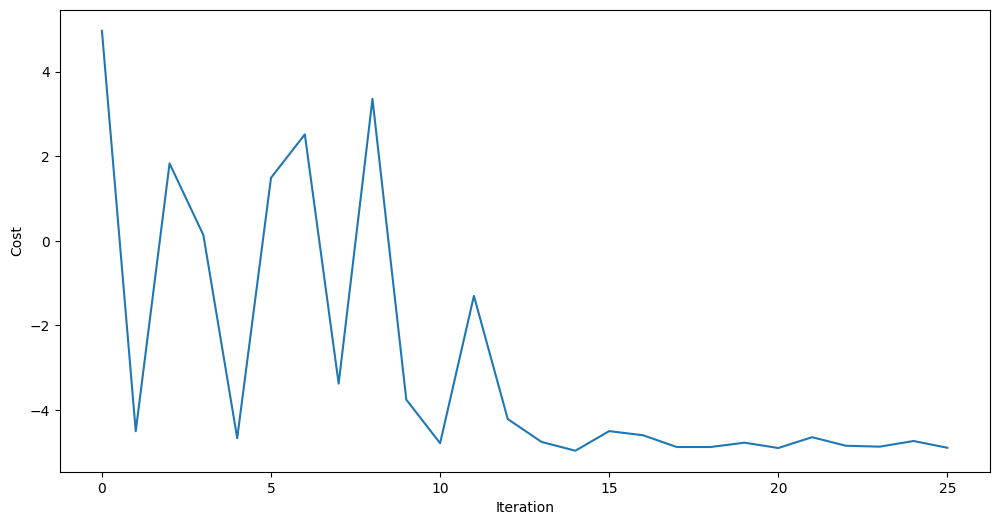

In [9]:
quantum.draw_objective_value()

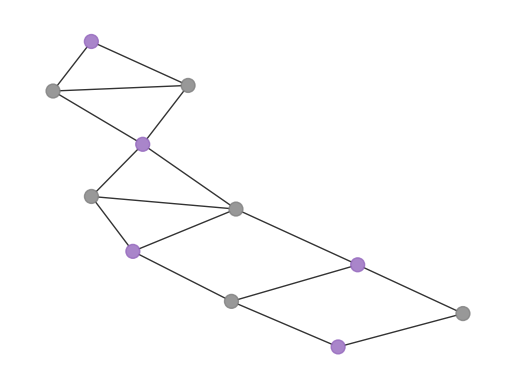

In [10]:
quantum.plot_result()

In [11]:

quantum.compare_solutions(solver.solve())

Objective to maximize: -2x_0*x_1-2x_0*x_2-2x_0*x_4-2x_0*x_7-2x_1*x_4-2x_1*x_9-2x_2*x_3-2x_2*x_4-2x_2*x_6-2x_3*x_5-2x_3*x_6-2x_5*x_6-2x_7*x_8-2x_7*x_9-2x_8*x_10-2x_9*x_10+4x_0+3x_1+4x_2+3x_3+3x_4+2x_5+3x_6+3x_7+2x_8+3x_9+2x_10 for relaxed = False
14.0
Result quantum [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1] Objective value:  14
Result input (classical) [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1] Objective Value:  14.0
Same solution True
Same objective function value:  True


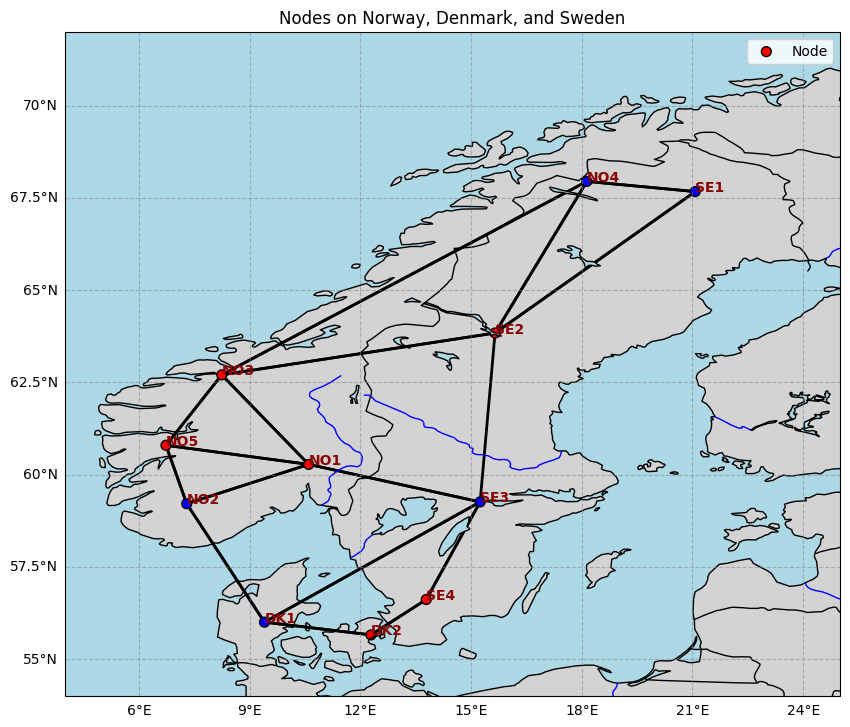

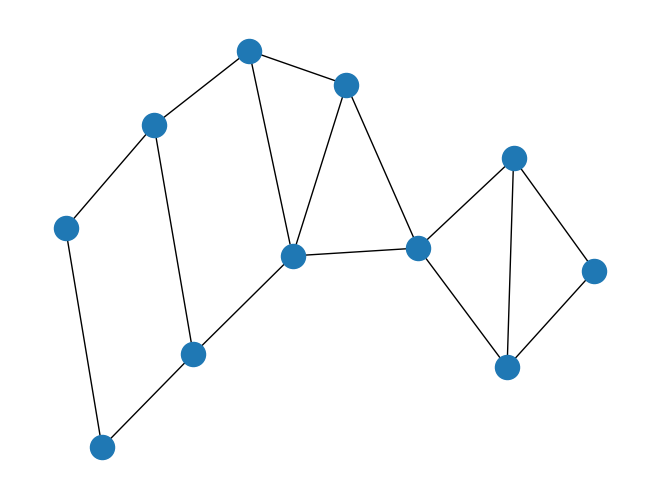

In [12]:
import csv

import numpy as np
import rustworkx as rx
from rustworkx import is_connected
from rustworkx.visualization import mpl_draw as draw_graph
import pandas as pd
import geopandas as gpd
import cartopy.feature as cfeature

def load_graph_from_csv(file_path):


    df = pd.read_csv(file_path,delimiter=';',index_col=0)
    #result = [(row_idx, col_idx, 1) for row_idx, row in enumerate(df.values) for col_idx, value in enumerate(row) if value == 1]
    graph = rx.PyGraph().from_adjacency_matrix(df.values.astype(np.float64))
    draw_graph(graph) 
    return graph

def load_edges_verbose(file_path):
    df = pd.read_csv(file_path,delimiter=';',index_col=0)
    result = [(row, col, 1) for (row, col), value in df.stack().items() if value == 1]
    return result

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

def draw_nodes_on_cartopy(file_path, bitstring=None):
    
    df = pd.read_csv(file_path, delimiter=';')
    edges = load_edges_verbose('data/11_nodes_links_scand.csv')
    
    # Rename the first column
    df.rename(columns={df.columns[0]: 'name'}, inplace=True)
    # Set up a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['y'], df['x']))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add map features
    ax.set_extent([4, 25, 54, 72], crs=ccrs.PlateCarree())  # Set the extent to cover Norway, Denmark, Sweden
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='black')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue')
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
  
    # Plot nodes on the map
    
    
    for start_label, end_label, weight in edges:
        start_coords = (df[df['name']==start_label]['y'], df[df['name']==start_label]['x'])
        end_coords = (df[df['name']==end_label]['y'], df[df['name']==end_label]['x'])
        ax.plot(
            [start_coords[0], end_coords[0]],  # x-coordinates (longitudes)
            [start_coords[1], end_coords[1]],  # y-coordinates (latitudes)
            color='black', linewidth=1 + weight, transform=ccrs.PlateCarree(), zorder=1
        )
    if bitstring is not None:
        colors = ['red' if bit == 1 else 'blue' for bit in bitstring]
    else:
        colors = 'red'
    
    gdf.plot(ax=ax, color=colors, markersize=50, transform=ccrs.PlateCarree(), edgecolor='black', label='Node')

    for idx, row in gdf.iterrows():
        ax.text(row.geometry.x + 0.005, row.geometry.y, row['name'], transform=ccrs.PlateCarree(),
                ha='left', fontsize=10, color='darkred', fontweight='bold')

    
    plt.legend()
    plt.title("Nodes on Norway, Denmark, and Sweden")
    plt.show()
draw_nodes_on_cartopy('data/11_nodes_coords_scand.csv', bitstring=[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])


load_graph_from_csv('data/11_nodes_links_scand.csv')


